In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import RobustScaler


%matplotlib inline

figsize = (20,6)
sns.set(rc={'figure.figsize':(20, 6)})

In [2]:
SHOW_PLOTS = True

In [3]:
def dist_plot(ser):
    g = sns.displot(ser, kind="kde")
    g.ax.set_title(f"Skewness: {round(ser.skew(),2)}")

In [4]:
def bar_plot(df, x_col, y_col, order=None):
    print(df[x_col].value_counts().sort_index())
    g = sns.barplot(x=df[x_col], y=df[y_col])

In [5]:
def unskew(df, cols, threshold=1.5, method='log'):
    for col in cols:
        if np.abs(df[col].skew()) > threshold:
            if method == 'sqrt':
                df[col] = df[col].apply(np.sqrt)
            else:
                df[col] = df[col].apply(lambda x: np.log(x) if x > 0 else 0)

In [6]:
def impute_one_column(df, consider, to_impute, missing_data=np.NaN, neighbors=10):
    imputer = KNNImputer(n_neighbors=neighbors, missing_values=missing_data)
    imputed_data = imputer.fit_transform(df[consider + [to_impute]])
    df_temp = pd.DataFrame(imputed_data, columns=[consider + [to_impute]])
    return df_temp[to_impute]

In [7]:
def impute_data(df):
    # basement
    df[BASEMENT_FTRS_FOR_IMPT] = df[BASEMENT_FTRS_FOR_IMPT].apply(lambda col: col.fillna(col.mode()[0]))
    
    # FireplaceQu
    df['FireplaceQu'] = impute_one_column(df, [ftr for ftr in CAT_WITH_ORDERING_FTRS if ftr != 'FireplaceQu'], 'FireplaceQu', -1)
    
    # Garage year built
    df['GarageYrBlt'] = impute_one_column(df, ['YearBuilt'], 'GarageYrBlt')

    # Garage quality and condition
    df['GarageQual'] = df['GarageQual'].median()
    df['GarageCond'] = df['GarageCond'].median()
    
    # Lot
    df['LotFrontage'] = impute_one_column(df, ['LotArea', '1stFlrSF', 'TotalBsmtSF', 'TotRmsAbvGrd'], 'LotFrontage')

In [8]:
def conver_to_numeric(df, cols_to_convert):
    df[cols_to_convert] = df[cols_to_convert].apply(lambda col: col.astype('category').cat.codes)

In [9]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


In [10]:
# load the training data
training = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv')
print(f'Training size: {training.shape[0]}')
training.head()

Training size: 1460


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [11]:
# load the test data
test = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv')
print(f'Test size: {test.shape[0]}')
test.head()

Test size: 1459


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [13]:
training.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [14]:
test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [15]:
# globals

ID = 'Id'
LABEL = SALE_PRICE = 'SalePrice'
BASEMENT_QUALITY, BASEMENT_CONDITION, BASEMENT_EXPOSURE, BASEMENT_FINISH_TYPE_1, BASEMENT_FINISH_TYPE_2 = 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'
CAT_WITH_ORDERING_FTRS = ['1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'ExterQual', 'GarageQual', 'GarageCond', 'FireplaceQu', 'LandSlope', 'HeatingQC',
                         'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'ExterCond', 'KitchenQual']

NUMERIC_FEATURES = training.select_dtypes(exclude=['object']).drop(['MSSubClass', ID], axis=1).columns.tolist()  # MSSubClass consists of numbers, but it's cat.
CAT_FEATURES = training.select_dtypes(include=['object']).columns.tolist() + ['MSSubClass']

exclude_features = set()  # will add to this on the go.

print(F'NUMERIC FEATURES: {len(NUMERIC_FEATURES)}')
print(F'CATEGORICAL FEATURES: {len(CAT_FEATURES)}')


NUMERIC FEATURES: 36
CATEGORICAL FEATURES: 44


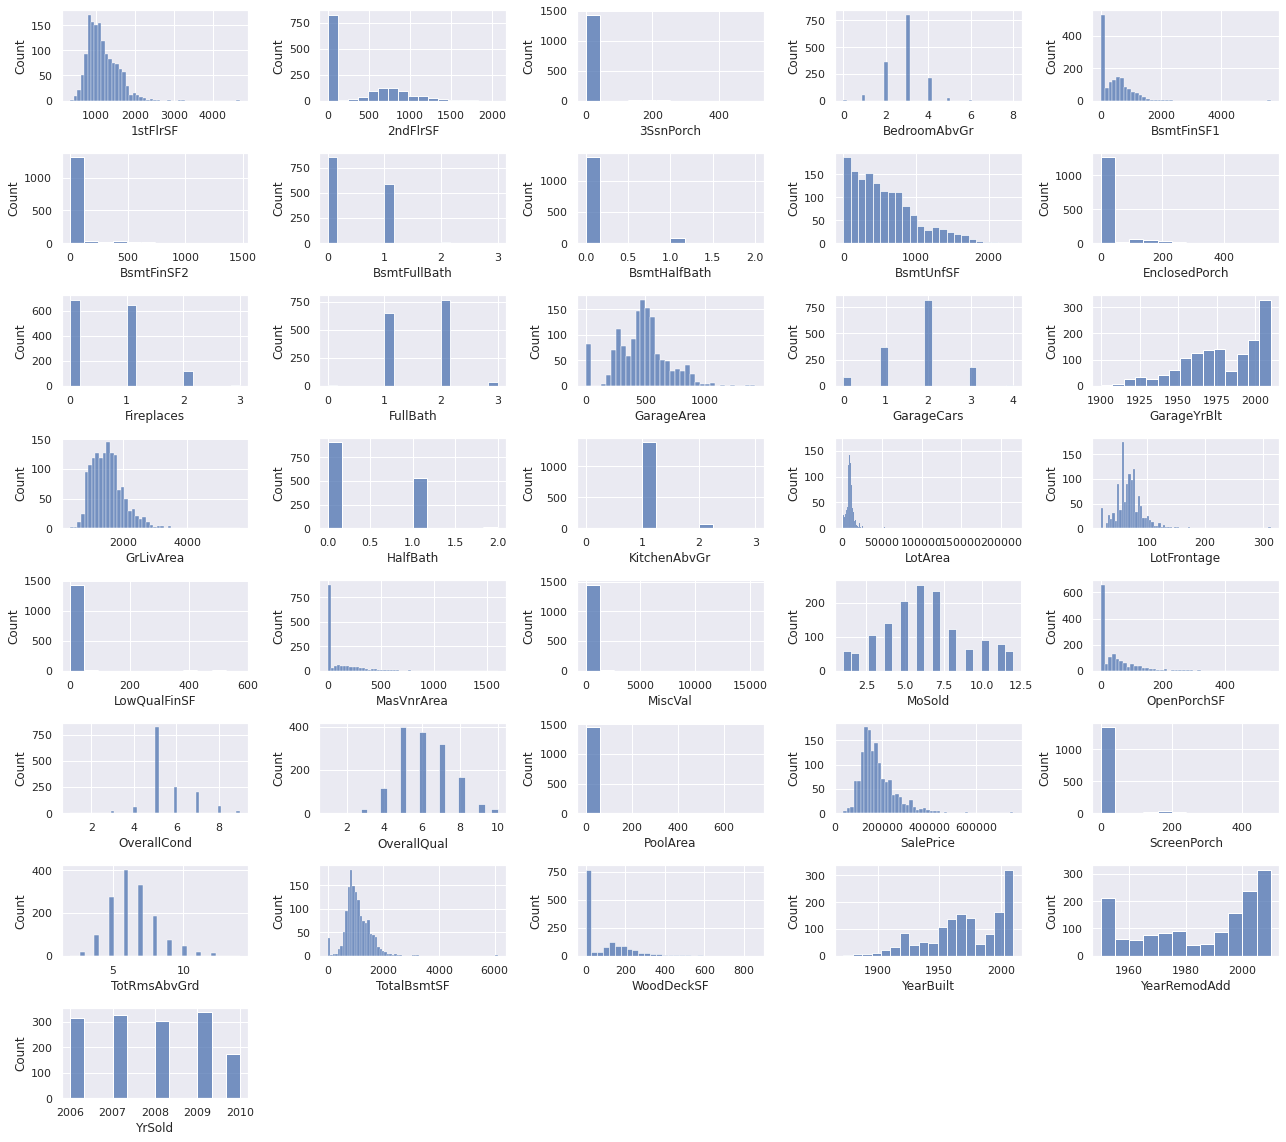

In [16]:
# explore numeric features

if SHOW_PLOTS:
    fig = plt.figure(figsize=(18,16))
    for i,col in enumerate(sorted(NUMERIC_FEATURES)):
        plt.subplot(8,5,i+1)
        sns.histplot(training[col].dropna())
    fig.tight_layout(pad=1.0)

In [17]:
# Remove / fix highly skewed features

# The following have a vast majority of one value. They won't help us. Just remove them:
# 3SsnPorch, BsmtFinSF2, EnclosedPorch, LowQualFinSF, MiscVal, PoolArea, ScreenPorch


exclude_features.update(['3SsnPorch', 'BsmtFinSF2', 'BsmtHalfBath', 'EnclosedPorch', 'KitchenAbvGr', 'LowQualFinSF', 'MiscVal', 'PoolArea', 'ScreenPorch'])

In [18]:
# continue - fix highly skewed features
features_to_unskew = ['2ndFlrSF', 'BsmtFinSF1', 'GrLivArea', 'MasVnrArea', 'WoodDeckSF']
#unskew(training, features_to_unskew)
#unskew(test, features_to_unskew)

# => Strangely enough this deteriorates the results... Should debug this

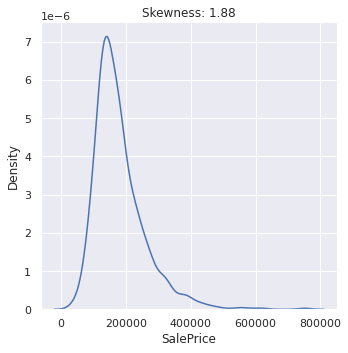

In [19]:
# plot label distribution

dist_plot(training[LABEL])

In [20]:
# label distribution is skewed. Unskew it (REMEMBER to inverse after prediction)
unskew(training, [LABEL], 1.0)

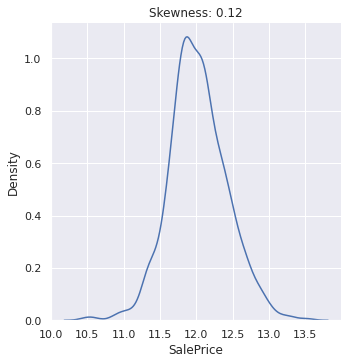

In [21]:
# plot label distribution again

dist_plot(training[LABEL])

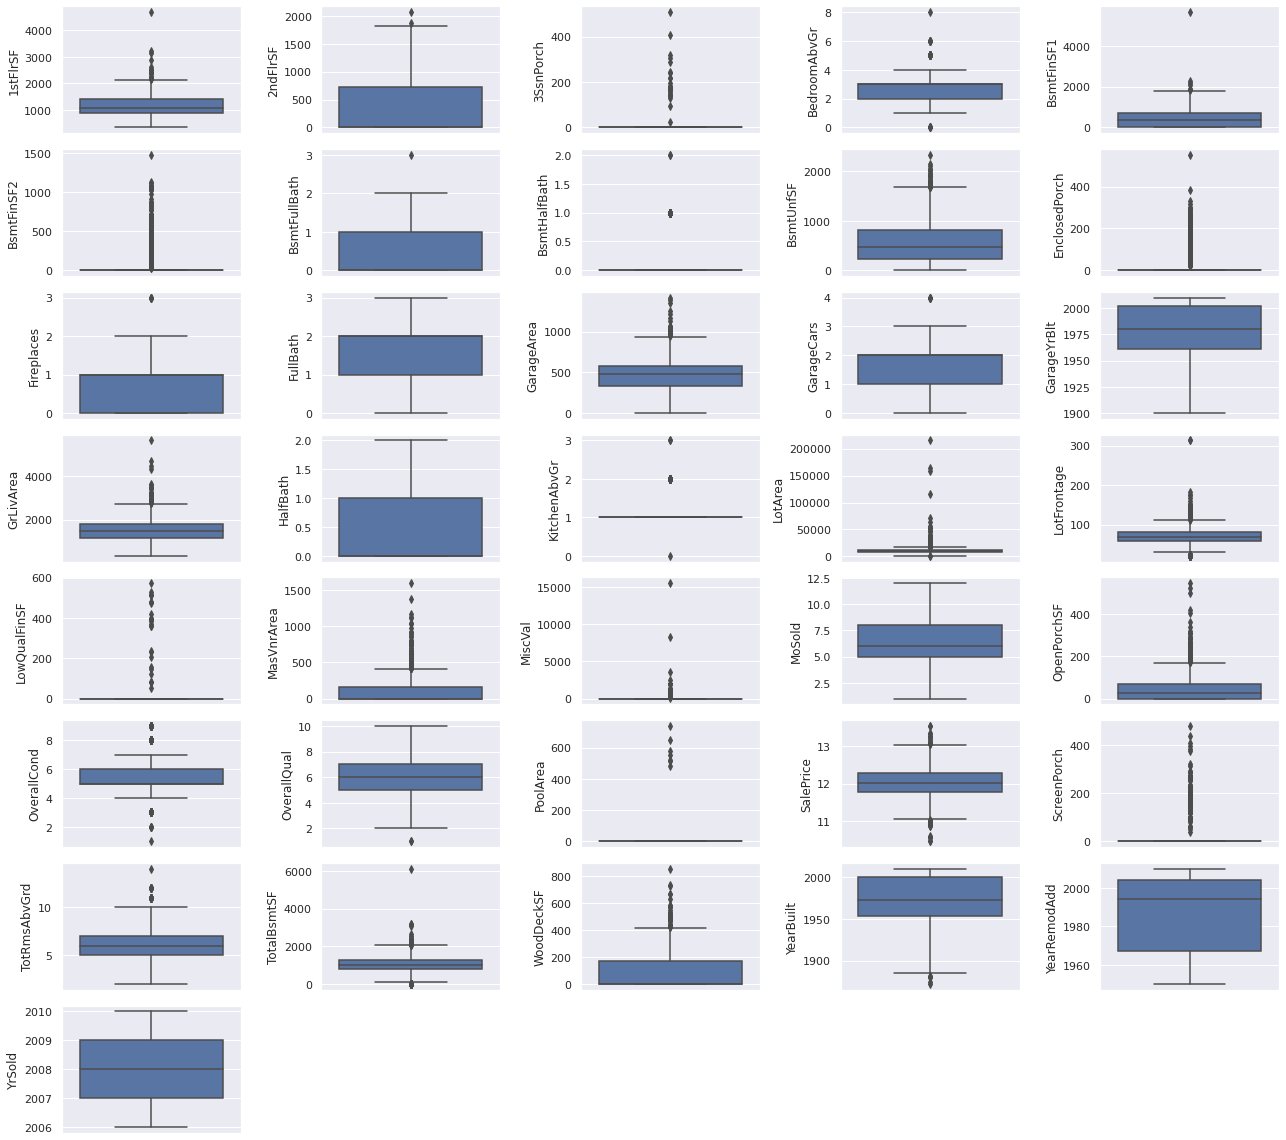

In [22]:
# detect outliers

if SHOW_PLOTS:
    fig = plt.figure(figsize=(18,16))
    for i,col in enumerate(sorted(NUMERIC_FEATURES)):
        plt.subplot(8,5,i+1)
        sns.boxplot(y=training[col])
    fig.tight_layout(pad=1.0)

In [23]:
# Remove outliers

training = training.drop(training[training['1stFlrSF'] > 4000].index)
training = training.drop(training[training['BsmtFinSF1'] > 4000].index)
training = training.drop(training[training['GrLivArea'] > 4000].index)
training = training.drop(training[training['LotArea'] > 100000].index)
training = training.drop(training[training['LotFrontage'] > 200].index)
training = training.drop(training[training['TotalBsmtSF'] > 4000].index)

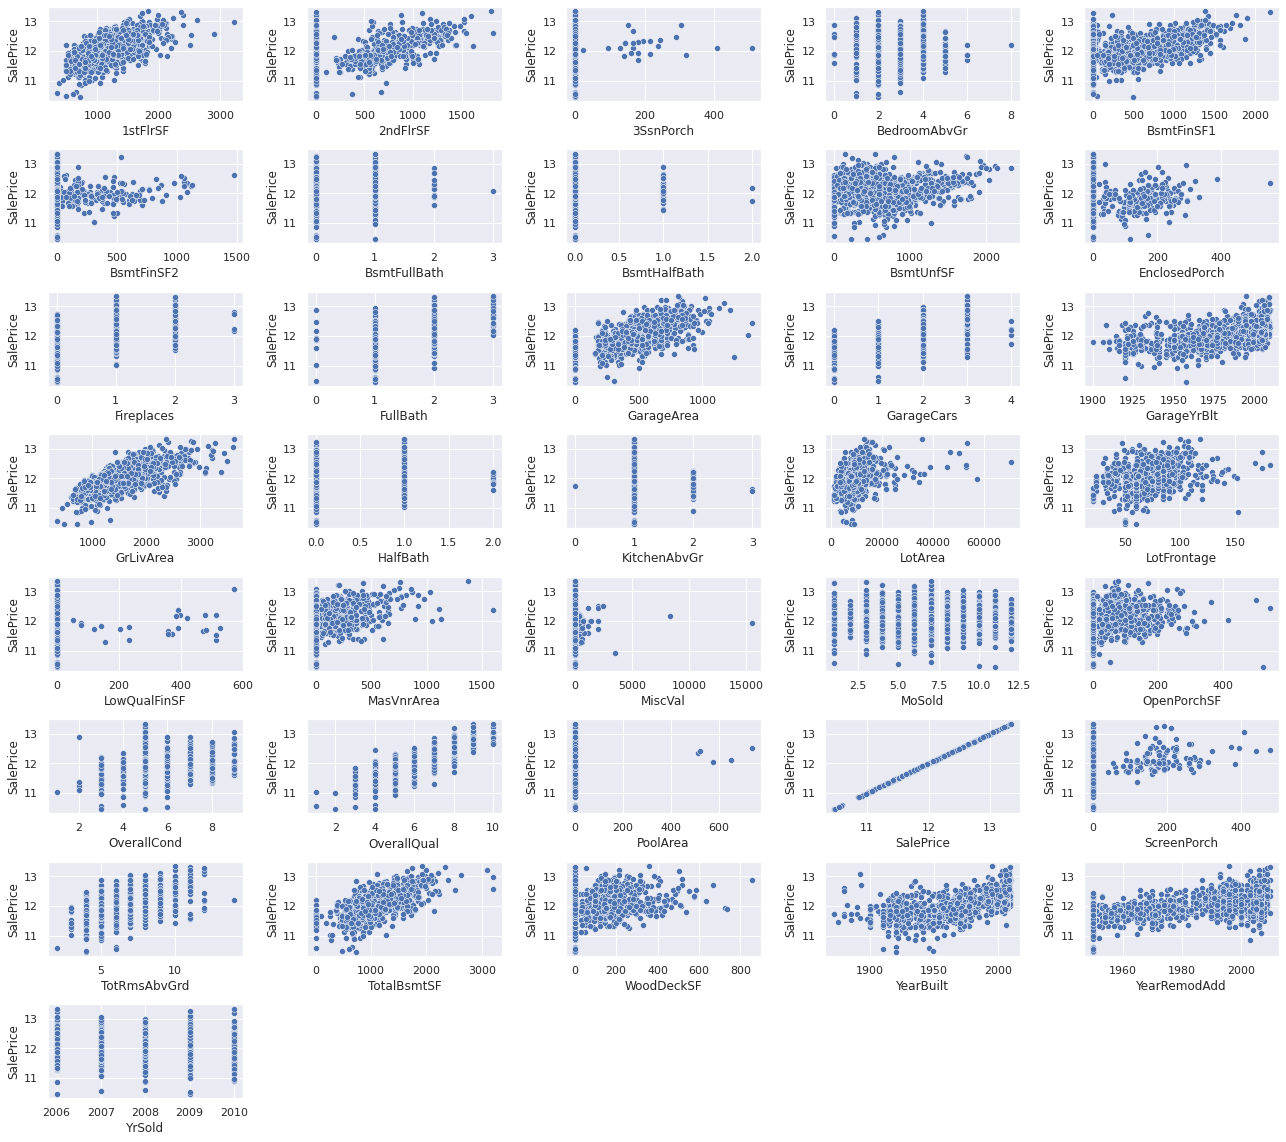

In [24]:
# Numerical features against label

if SHOW_PLOTS:
    fig = plt.figure(figsize=(18,16))
    for i,col in enumerate(sorted(NUMERIC_FEATURES)):
        plt.subplot(8,5,i+1)
        sns.scatterplot(x=training[col].dropna(), y=training[LABEL])
    fig.tight_layout(pad=1.0)

In [25]:
# Observations:

# Some features are obviously correlated with the label, and therefore are very important. E.g.:
# 1stFlrSF, 2ndFlrSF, BsmtFinSF1, GarageArea, GrLivArea, TotalBsmtSF
# So we should include those.

# Some features have no correlation with the label. And some of them were already removed. Such as PoolArea and KitchenAbvGr.
# Others that haven't been removed already, and should be removed: YrSold, MoSold. They're obviously non-informative.
# Remove them:
exclude_features.update(['YrSold', 'MoSold'])

In [26]:
# Investigate Nans

print('Nans:')
ser = training.isna().sum()
ser[ser > 0]

Nans:


LotFrontage      256
Alley           1360
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1446
Fence           1171
MiscFeature     1399
dtype: int64

In [27]:
print('Nans%:')
ser = (training.isna().sum() / training.shape[0]) * 100
ser[ser > 0]

Nans%:


LotFrontage     17.643005
Alley           93.728463
MasVnrType       0.551344
MasVnrArea       0.551344
BsmtQual         2.549966
BsmtCond         2.549966
BsmtExposure     2.618884
BsmtFinType1     2.549966
BsmtFinType2     2.618884
Electrical       0.068918
FireplaceQu     47.553411
GarageType       5.582357
GarageYrBlt      5.582357
GarageFinish     5.582357
GarageQual       5.582357
GarageCond       5.582357
PoolQC          99.655410
Fence           80.702963
MiscFeature     96.416265
dtype: float64

In [28]:
# Drop small nans (other nans we'll have to impute)

training = training.dropna(subset=['MasVnrType', 'MasVnrArea', 'Electrical']).reset_index(drop=True)
training_nan_ser = training.isna().sum()
training_nan_ser[training_nan_ser > 0]

LotFrontage      254
Alley           1352
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      685
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1437
Fence           1162
MiscFeature     1390
dtype: int64

In [29]:
# Many features here are categorical. Let's see if we should convert them to numeric or one hot encoding etc.
# We'll skip numeric features here since they're obvious, and will skip features with too many Nans since we won't use them.

# MSSubClass: the ID here (20 / 30 / 40 / ...) has no meaning. But Looks like it's worth to parse the values and create a new feature from this.
# MSZoning: No meaning, but we can parse and create new feature.
# Street (type): 2 categories => either one hot encoding or convert to numerical 0 / 1
# LotShape: 4 cats => one hot
# LandContour: 4 cats => one hot
# Utilities: 4 cats => one hot
# LotConfig: 4 cats => one hot
# LandSlope: 3 cats but the ordering has a meaning => convert to numerical
# Neighborhood: too many cats. either one hot encoding, or some type of grouping, or don't use at all.
# Condition1: 9 cats, can do grouping here.
# Condition2: 9 cats, can do grouping here.
# also can combine between Condition1 & Condition2 somehow.
# BldgType: 5 cats: 1fam / 2fam / dup / twn end unit / twn inside unit. Not sure if numerical will help... but it might. need to examing this feature more.
# HouseStyle: 8 cats. one hot, and can extract 1 or 2 new features from this (num of stories / 2nd level finished unfinished)
# RoofStyle: 6 cats. 1 hot.
# RoofMatl: 8 cats. 1 hot.
# Exterior1st: too many cats. group then 1 hot.
# Exterior2nd: too many cats. group then 1 hot.
# MasVnrType: 5 cats. Examine feature. Either 1 hot as is or group.
# ExterQual: cats with meaningful ordering. convert to numeric.
# ExterCond: cats with meaningful ordering. convert to numeric.
# Foundation: 6 cats. 1 hot.
# Basement features: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2: cats with ordering importance. convert to numeric.
# Heating: 6 cats. 1 hot.
# HeatingQC: 5 cats with ordering. convert to numeric.
# CentralAir: yes / no. either one hot encoding or convert to numerical 0 / 1
# Electrical: 5 cats. either 1 hot or first group to 3 cats and then 1 hot.
# KitchenQual: 5 grading cats. convert to numeric.
# Functional: group to: typical / minor / moderate / major / severe/ salvage, and convert to numeric, or conver to numeric as is. Not sure what salvage means.
# FireplaceQu: 6 grading cats. convert to numeric.
# GarageType: 7 cats: one hot.
# GarageFinish: 4 cats. one hot.
# GarageQual: 6 grading cats. convert to numeric.
# GarageCond: 6 grading cats. convert to numeric.
# PavedDrive: 3 cats. 1 hot.
# MoSold: although numeric, we might want to group to seasons for example.
# SaleType: 10 cats. need to examin feature. not sure what it means.
# SaleCondition: 6 cats. one hot.

# So we're down to ~38 categorical features, and ~31 numeric. The rest won't be used.

In [30]:
# convert cat with ordering to numeric

conver_to_numeric(training, CAT_WITH_ORDERING_FTRS)  # note: nans become -1
conver_to_numeric(test, CAT_WITH_ORDERING_FTRS)  # note: nans become -1

In [31]:
# TODO: Can try groupifying as discussed above

In [32]:
# Data imputation

# let's see how features with missing data look
training[training_nan_ser[training_nan_ser > 0].index].head()

,LotFrontage,Alley,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,MiscFeature
0,65.0,NaN,2,3,3,2,5,-1,Attchd,2003.0,RFn,4,4,NaN,NaN,NaN
1,80.0,NaN,2,3,1,0,5,4,Attchd,1976.0,RFn,4,4,NaN,NaN,NaN
2,68.0,NaN,2,3,2,2,5,4,Attchd,2001.0,RFn,4,4,NaN,NaN,NaN
3,60.0,NaN,3,1,3,0,5,2,Detchd,1998.0,Unf,4,4,NaN,NaN,NaN
4,84.0,NaN,2,3,0,2,5,4,Attchd,2000.0,RFn,4,4,NaN,NaN,NaN


In [33]:
# Data imputation - continue

training_nan_ser = training.replace(-1, np.NaN).isna().sum()
training_nan_ser[training_nan_ser > 0]

LotFrontage      254
Alley           1352
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      685
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1437
Fence           1162
MiscFeature     1390
dtype: int64

In [34]:
# Data imputation - continue

# LotFrontage: 

# Alley: Vast majority is missing. Will not use this feature.

# BsmtQual (basement):
# BsmtCond:
# BsmtExposure:
# BsmtFinType1:
# BsmtFinType2: 
# => These are categorical features, and relatively few are missing. Take most repeated value.

# FireplaceQu: Fireplace quality, 6 options (categorical): NA / Poor / ... / Excellent. About half are missing. Impute with KNN.

# GarageType (location): 6 options (categorical). ~5% are missing. Leave as Nan.
# GarageYrBlt: numeric, 5% missing. Impute with KNN.
# GarageFinish: 4 categories, 5% missing. Leave as Nan.
# GarageQual: 6 cats with ordering, 5% missing. => no correlating features. take median.
# GarageCond: 6 cats with ordering, 5% missing. => no correlating features. take median.

# PoolQC (pool quality): 99% missing. Don't take this feature.

# Fence: 80% missing. Will not use this feature.

# MiscFeature: Vast majority is missing. Will not use this feature.

In [35]:
exclude_features.update(['Alley', 'PoolQC', 'Fence', 'MiscFeature'])

In [36]:
BASEMENT_FTRS_FOR_IMPT = [BASEMENT_CONDITION, BASEMENT_EXPOSURE, BASEMENT_FINISH_TYPE_1, BASEMENT_FINISH_TYPE_2, BASEMENT_QUALITY]
GARAGE_FTRS_FOR_IMPT = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

# basement
#1. #training[BASEMENT_FTRS_FOR_IMPT] = training[BASEMENT_FTRS_FOR_IMPT].apply(lambda col: col.fillna(col.mode()[0]))

# FireplaceQu
#training['FireplaceQu'].astype('category').cat.codes
# before imputing with KNN, we need to see which features are correlated with it the most.
# let's try some numerical features first and see if they're good candidates.
# but first need to make FireplaceQu numeric.
#numeric_FireplaceQu = training['FireplaceQu'].astype('category').cat.codes
#some_numeric_ftrs = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
#temp_df = training[some_numeric_ftrs]
#temp_df['numeric_FireplaceQu'] = numeric_FireplaceQu
#g = sns.heatmap(temp_df[['numeric_FireplaceQu'] + some_numeric_ftrs].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", vmin=-1, vmax=1)
# => unfortunately, nothing is strongly correlated with it.
# best are: '1stFlrSF', 'TotRmsAbvGr', 'FullBath'

# try other features (categorical with ordering meaning):
#ftrs_to_try = ['LandSlope', 'ExterQual', 'ExterCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
#temp_df = training[ftrs_to_try].apply(lambda col: col.astype('category').cat.codes)
#temp_df['numeric_FireplaceQu'] = numeric_FireplaceQu
#g = sns.heatmap(temp_df[['numeric_FireplaceQu'] + ftrs_to_try].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", vmin=-1, vmax=1)
# ==> not so much... 'ExterQual', 'GarageQual', 'GarageCond' are best... but not so good

# try the basement features
#temp_df = training[BASEMENT_FTRS_FOR_IMPT].apply(lambda col: col.astype('category').cat.codes)
#temp_df['numeric_FireplaceQu'] = numeric_FireplaceQu
#g = sns.heatmap(temp_df[['numeric_FireplaceQu'] + BASEMENT_FTRS_FOR_IMPT].corr(),annot=True, fmt = ".2f", cmap = "coolwarm", vmin=-1, vmax=1)
# => nothing

# so the verdict is to consider the following:
# '1stFlrSF', 'TotRmsAbvGrd', 'FullBath', 'ExterQual', 'GarageQual', 'GarageCond'

#temp = CAT_WITH_ORDERING_FTRS[:]
#temp.remove('FireplaceQu')
#print(training['FireplaceQu'])
#2. #training['FireplaceQu'] = impute_one_column(training, temp, 'FireplaceQu', -1)
#print(training['FireplaceQu'])
#training[CAT_WITH_ORDERING_FTRS].apply(lambda col: col.unique())

# Garage
# check correlation
#some_numeric_ftrs = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
#temp_df = training[some_numeric_ftrs + ['GarageYrBlt']]
#g = sns.heatmap(temp_df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", vmin=-1, vmax=1)
# => 'GarageYrBlt' Very highly correlated with YearBuilt!
#3. training['GarageYrBlt'] = impute_one_column(training, ['YearBuilt'], 'GarageYrBlt')

#features_to_check = ['GarageYrBlt', 'GarageQual', 'GarageCond']
#temp_df = training[some_numeric_ftrs + features_to_check]
#g = sns.heatmap(temp_df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", vmin=-1, vmax=1)
# => GarageQual and GarageCond are very correlated with each other. but maybe they get missing together... let's check

#training.loc[(training['GarageQual'] == -1) | (training['GarageCond'] == -1), ['GarageQual', 'GarageCond']]
#training.loc[(training['GarageQual'] == -1) & (training['GarageCond'] != -1), ['GarageQual', 'GarageCond']]
#training.loc[(training['GarageQual'] != -1) & (training['GarageCond'] == -1), ['GarageQual', 'GarageCond']]

# => yup. they go missing together. so can't infer one from the other.
# so let's just take median.
#4. #training['GarageQual'] = training['GarageQual'].median()
#5. #training['GarageCond'] = training['GarageCond'].median()

# LotFrontage
#import random
#some_numeric_ftrs = ['LotArea', 'YearBuilt', '1stFlrSF', '2ndFlrSF', 'FullBath', 'BedroomAbvGr', 'TotRmsAbvGrd']
#temp_df = training[random.sample(NUMERIC_FEATURES, 7) + ['LotFrontage']]
#temp_df = training[['LotArea', '1stFlrSF', 'TotRmsAbvGrd', 'TotalBsmtSF'] + ['LotFrontage']]
#g = sns.heatmap(temp_df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm", vmin=-1, vmax=1)
# LotArea is Ok and maybe 1stFlrSF and TotalBsmtSF, and maybe maybe TotRmsAbvGrd
#training['LotFrontage'].describe() std is large... can't take mean or median
# so use knn but it won't be very good... it's the best out of the worst...

#6. #training['LotFrontage'] = impute_one_column(training, ['LotArea', '1stFlrSF', 'TotalBsmtSF', 'TotRmsAbvGrd'], 'LotFrontage')

In [37]:
impute_data(training)
impute_data(test)

print('Nans:')
ser = training.isna().sum()
ser[ser > 0]

Nans:


Alley           1352
GarageType        81
GarageFinish      81
PoolQC          1437
Fence           1162
MiscFeature     1390
dtype: int64

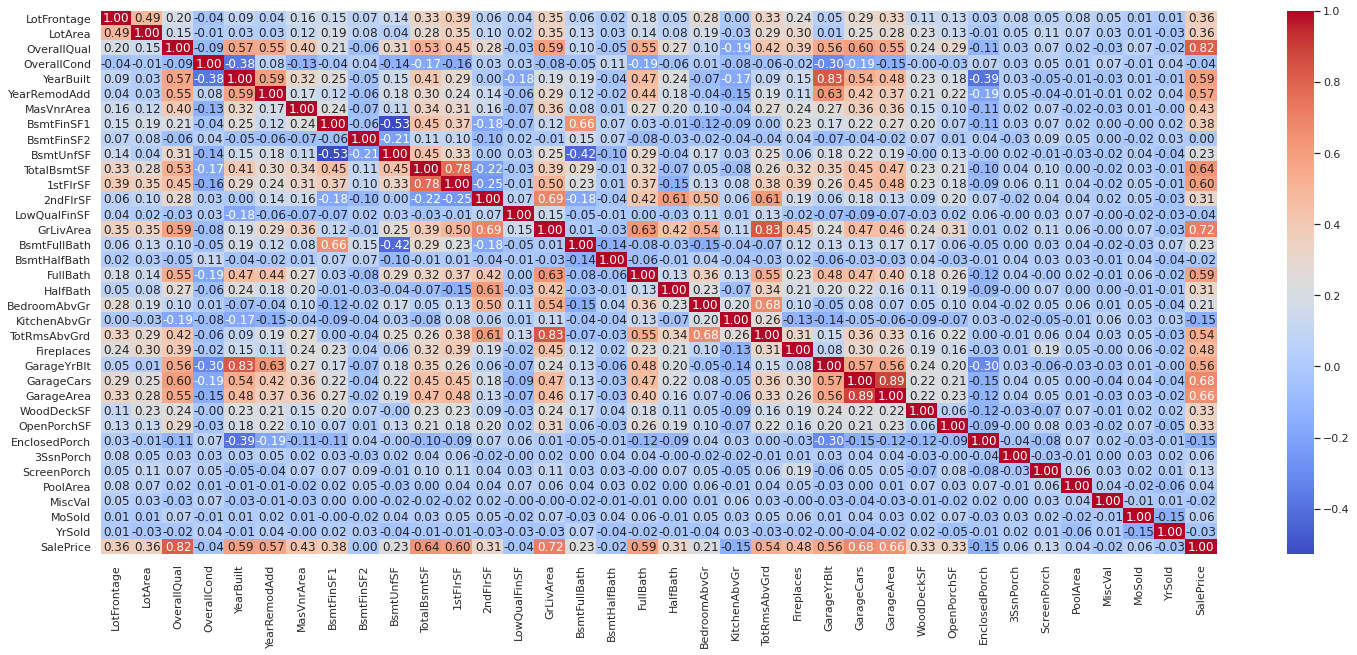

In [38]:
# Check for correlation between numerical and label, and in-between numerical

temp_df = training[NUMERIC_FEATURES]
plt.figure(figsize=(25,10))
g = sns.heatmap(temp_df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [39]:
# Correlation with label

temp_df.corr()[LABEL].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.820402
GrLivArea        0.718694
GarageCars       0.680531
GarageArea       0.655430
TotalBsmtSF      0.640769
1stFlrSF         0.597888
YearBuilt        0.591731
FullBath         0.590807
YearRemodAdd     0.570893
GarageYrBlt      0.559200
TotRmsAbvGrd     0.536897
Fireplaces       0.484837
MasVnrArea       0.430863
BsmtFinSF1       0.377026
LotFrontage      0.362574
LotArea          0.360613
WoodDeckSF       0.332995
OpenPorchSF      0.325936
HalfBath         0.314238
2ndFlrSF         0.312076
BsmtFullBath     0.231962
BsmtUnfSF        0.228133
BedroomAbvGr     0.206775
ScreenPorch      0.127112
MoSold           0.060673
3SsnPorch        0.057467
PoolArea         0.041459
BsmtFinSF2       0.001293
BsmtHalfBath    -0.016804
MiscVal         -0.020814
YrSold          -0.033100
OverallCond     -0.035662
LowQualFinSF    -0.036874
EnclosedPorch   -0.148002
KitchenAbvGr    -0.149465
Name: SalePrice, dtype: float64

In [40]:
# Observations:
# Some features have a high correlation with LABEL. E.g. OveralQual and GrLivArea. That's great, we will use them.
# Other features have close-to-zero clorrelation. We can remove them. E.g. BsmtFinSF2

exclude_features.update(['BsmtFinSF2', 'BsmtHalfBath'])

In [41]:
# Remove highly correlated features, because they can degrade the Regressor's performance (let the ones with a higher correlation with LABEL stay).

# GarageArea is highly correlated with GarageCars, and GarageCars has a higher correlation with the label. So choose it to stay, and remove GarageArea.
# GarageYrBlt vs YearBuilt => YearBuild wins.
# BsmtUnfSF vs BsmtFinSF1: BsmtFinSF1 wins.
# GrLivArea vs TotRmsAvbGrd: GrLivArea wins

exclude_features.update(['GarageArea', 'GarageYrBlt', 'BsmtUnfSF', 'TotRmsAvbGrd'])

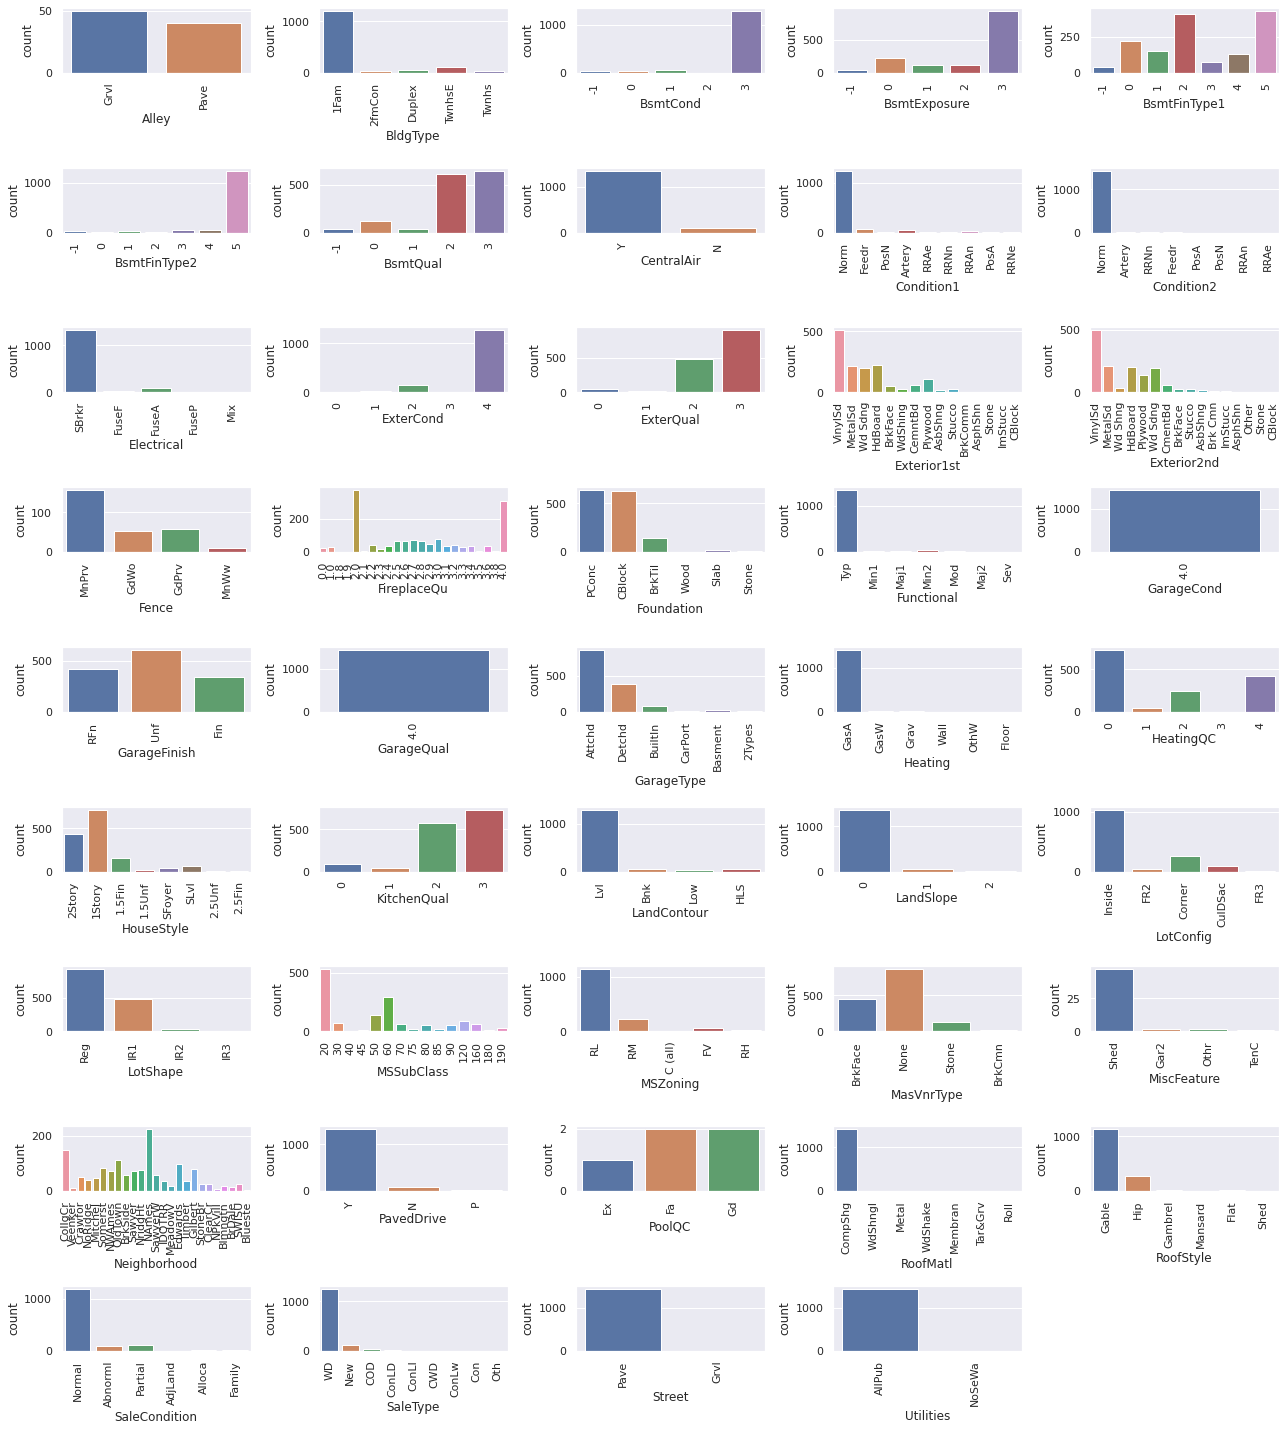

In [42]:
# Explore categorical features

fig = plt.figure(figsize=(18,20))
for i,col in enumerate(sorted(CAT_FEATURES)):
    plt.subplot(9,5,i+1)
    sns.countplot(x=training[col])
    plt.xticks(rotation=90)
fig.tight_layout(pad=1.0)

In [43]:
# Remove highly skewed features

# The following features have a vast majority of 1 value:
# Condition2, GarageCond, GarageQual, Heating, RoofMatl, Street, Utilities
# Just remove them. They won't help us.

exclude_features.update(['Condition2', 'GarageCond', 'GarageQual', 'Heating', 'RoofMatl', 'Street', 'Utilities'])

SalePrice       1.000000
BsmtCond        0.197508
BsmtFinType2    0.157210
ExterCond       0.145924
LandSlope       0.012485
BsmtFinType1   -0.017814
MSSubClass     -0.073352
FireplaceQu    -0.101657
BsmtExposure   -0.151021
BsmtQual       -0.368725
HeatingQC      -0.430186
KitchenQual    -0.530756
ExterQual      -0.585255
Name: SalePrice, dtype: float64

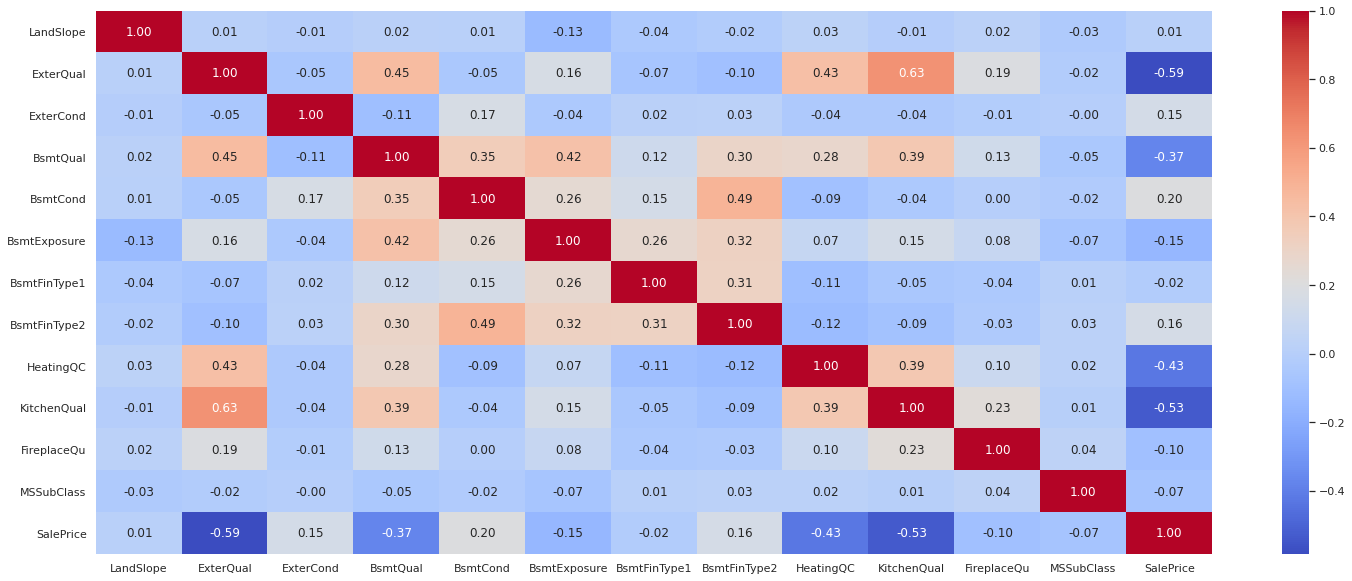

In [44]:
# Correlation with label  (we can do this now because we already transformed CAT to NUM)

temp_df = training[[ftr for ftr in CAT_FEATURES if ftr not in exclude_features] + [LABEL]]
plt.figure(figsize=(25,10))
g = sns.heatmap(temp_df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

temp_df.corr()[LABEL].sort_values(ascending=False)

In [45]:
# Observations:

# The most correlated with LABEL are:
# ExterQual, BstmQual, HeatingQC, KitchenQual

# LandSlope has the lowest correlation, it's almost zero. Remove this one.
exclude_features.update(['LandSlope'])

# KitchenQual and ExterQual have the highest correlation with each other. Let's try removing one of them
exclude_features.update(['KitchenQual'])

In [46]:
# Model

# Prepare data for prediction

features = [ftr for ftr in NUMERIC_FEATURES if ftr != LABEL] + CAT_FEATURES
features = [ftr for ftr in features if ftr not in exclude_features]

y_train = training[LABEL]

alldata = training.append(test).reset_index(drop=True)
alldata.fillna(np.NaN, inplace=True)
alldata = pd.get_dummies(alldata[features])

X_train = alldata.iloc[:training.shape[0]]
X_test = alldata.iloc[training.shape[0]:].apply(lambda col: col.fillna(col.dropna().mean()))

In [47]:
# Evaluation


rf = RandomForestRegressor(random_state=1)
gb = GradientBoostingRegressor(random_state=1)
#lr = LinearRegression()  # wasn't good
ls = Lasso(random_state=1, max_iter=5000)  # https://www.kaggle.com/cheesu/house-prices-1st-approach-to-data-science-process
rg = Ridge(random_state=1)  # https://www.kaggle.com/cheesu/house-prices-1st-approach-to-data-science-process

clfs = [rf, gb, ls, rg]
for clf in clfs:
    print(clf.__class__.__name__)
    cv = cross_val_score(clf, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
    print(f'Cross validation scores: {cv}')
    print(f'Cross validation avg score: {cv.mean()}')
    print('')


RandomForestRegressor
Cross validation scores: [-0.09635706 -0.09437249 -0.09510625 -0.09104212 -0.09568854]
Cross validation avg score: -0.0945132941339803

GradientBoostingRegressor
Cross validation scores: [-0.08590258 -0.08565496 -0.08568938 -0.08198355 -0.08922911]
Cross validation avg score: -0.08569191313016648

Lasso
Cross validation scores: [-0.12222378 -0.12276016 -0.12193962 -0.12336594 -0.12831865]
Cross validation avg score: -0.12372163044327567

Ridge
Cross validation scores: [-0.07712486 -0.08105778 -0.08369828 -0.07487571 -0.08059062]
Cross validation avg score: -0.07946944985697792



In [48]:
# fit on all the data
for clf in clfs:
    clf.fit(X_train, y_train)

<AxesSubplot:>

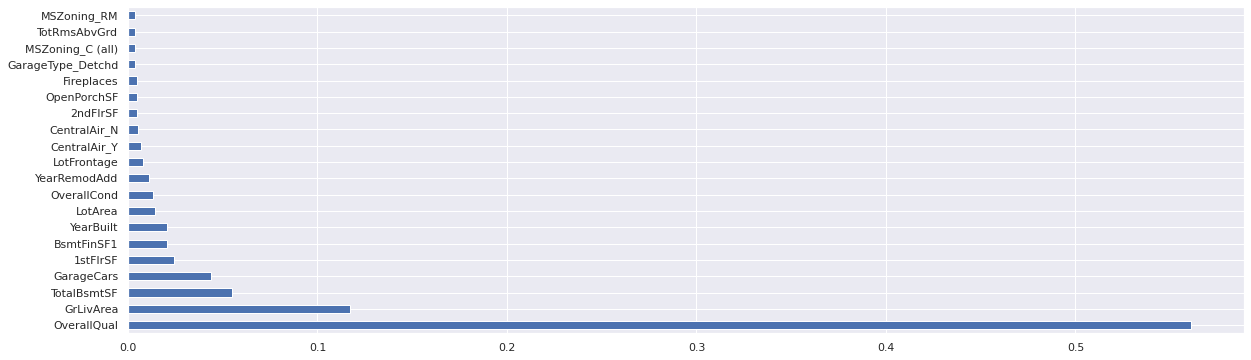

In [49]:
# visualize best features (RF only)
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [50]:
# ensemble

voting_clf = VotingRegressor(estimators = [('rf',rf), ('gb',gb), ('rg', rg)]) 
cv_mae = cross_val_score(voting_clf, X_train, y_train, cv=5, scoring="neg_mean_absolute_error")
cv_acc = cross_val_score(voting_clf, X_train, y_train, cv=5)
print('Ensemble:')
print(cv_mae)
print(cv_mae.mean())
print(cv_acc)
print(cv_acc.mean())

Ensemble:
[-0.07819942 -0.07747466 -0.0810778  -0.0756862  -0.079154  ]
-0.07831841872277594
[0.92007238 0.92315404 0.90474136 0.92179346 0.90813848]
0.9155799447369745


In [51]:
voting_clf.fit(X_train, y_train)

VotingRegressor(estimators=[('rf', RandomForestRegressor(random_state=1)),
                            ('gb', GradientBoostingRegressor(random_state=1)),
                            ('rg', Ridge(random_state=1))])

In [52]:
# generate predictions
# predictions = gb.predict(X_test)
# predictions = rf.predict(X_test)
predictions = voting_clf.predict(X_test)  # ==> RESULTS ON TEST: 13833.85252
output = pd.DataFrame({ID: test[ID], LABEL: np.exp(predictions)})
output.to_csv('submission.csv', index=False)
print('Submission saved')

Submission saved
